In [80]:
import random
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy.stats
import datetime as dt

import FXOption_class

In [2]:
#for graphs to be contained inside notebook
%matplotlib inline

In [3]:
#code check debug
volume = 25000
dev = 2500
mean = 2*math.log(volume) - 0.5*math.log(dev*dev+ volume * volume)
var = -2 * math.log(volume) + math.log(dev *dev + volume * volume)
stdev = math.sqrt(var)cp85
print(mean, stdev)
for i in range(5):
    xp = np.random.lognormal(mean, stdev)
    print(xp)

10.121655938423753 0.09975134511959609
22185.99109743756
24197.95571863633
20980.085394520982
25697.688096959257
26825.163271841066


In [81]:


class PayoffProfiles(object):
    
    def __init__(self, revs_unit_price_local, mean_volume_log, sigma_volume_log, \
                mean_spot_log, sigma_spot_log, var_cost, fixed_cost):
        
        self.revs_unit_price_local = revs_unit_price_local  #deterministic price of whatever client sells, say in USD
        
        self.mean_volume_log = mean_volume_log   #stochastic expected mean of volumes sold
        self.sigma_volume_log = sigma_volume_log  #stochastic expected stDev of volumes sold.  
        
        self.mean_spot_log = mean_spot_log  #expected FX rate, can use forward
        self.sigma_spot_log =  sigma_spot_log #expected FX vol, can use at-the money implieds
        self.var_cost = var_cost
        self.fixed_cost = fixed_cost
        
        '''https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.lognormal.html
 Note that the mean and standard deviation are not the values for the distribution itself,
but of the underlying normal distribution it is derived from, thus transforming using: 

https://ocw.mit.edu/courses/civil-and-environmental-engineering/1-151-probability-
     and-statistics-in-engineering-spring-2005/lecture-notes/briefnts8_relnl.pdf''' 
        
    def _draw_volume_(self):#  dont need the other 2 args,mean_volume_log, sigma_volume_log):
        
        #helper method, takes as input lognormal mean and stdev, transforms to normal, and makes a random draw
        mean_volume_norm = 2*math.log(self.mean_volume_log) - 0.5*math.log((self.sigma_volume_log**2) \
                                                                           + self.mean_volume_log **2)
        variance_volume_norm = -2 * math.log(self.mean_volume_log) + math.log((self.sigma_volume_log **2) + self.mean_volume_log**2)
        
        sigma_volume_norm = math.sqrt(variance_volume_norm)
    
        volume = np.random.lognormal(mean_volume_norm, sigma_volume_norm)
        return volume

    def _draw_spot_(self):
        
        #helper method, takes as input lognormal mean and stdev, transforms to normal, and makes a random draw
    
        mean_spot_norm = 2*math.log(self.mean_spot_log) - 0.5*math.log((self.sigma_spot_log**2) \
                                                                       + self.mean_spot_log **2)
        variance_spot_norm = -2 * math.log(self.mean_spot_log) + math.log((self.sigma_spot_log **2)\
                                                                     +  self.mean_spot_log**2)
        sigma_spot_norm = math.sqrt(variance_spot_norm)
    
        spot  = np.random.lognormal(mean_spot_norm,sigma_spot_norm)
    
        return spot
    
    def unhedged_profile(self, num_draws):
        
         #i receive USD but have expenses in EUR, thus im short EURUSD so i buy if hedged#
        
        profit_vec = []
        draws = 0
        while draws <= num_draws:
            volume = self._draw_volume_()
            #spot = draw_spot_(self.mean_spot_log, self.sigma_spot_log)  or
            spot = self._draw_spot_()

            profit = self.revs_unit_price_local * volume - spot * self.var_cost * volume - self.fixed_cost 
            
            profit_vec.append(profit)
            draws += 1
   
        mean_profit = np.mean(profit_vec)
        min_profit = min(profit_vec)
        std_profit = np.std(profit_vec)
        skew_profit = scipy.stats.skew(profit_vec)
    
        print('mean '+str(mean_profit))
        print('stDev: '+str(std_profit)) 
        print('min :' +str(min_profit))
        print('skew :' +str(skew_profit))
        count, bins, ignored = plt.hist(profit_vec , 100, normed = True)
        plt.plot()
        
    #distribution of profits hedged with forward
    def hedged_profit_forward(self, num_draws):


        hedge_notional = self.mean_volume_log*self.var_cost  #hedging with full expected revenue
        forward_rate_t0 = self.mean_spot_log #can make it actual forward later 
    
        profit_vec = []
        draws = 0
        
        while draws <= num_draws:
            volume = self._draw_volume_()

            spot = self._draw_spot_() 
            #print(spot)
            profit = self.revs_unit_price_local * volume - spot * self.var_cost * volume - self.fixed_cost  +hedge_notional*\
            (spot - forward_rate_t0)
            profit_vec.append(profit)
            draws += 1
   
        mean_profit = np.mean(profit_vec)
        min_profit = min(profit_vec)
        std_profit = np.std(profit_vec)
        skew_profit = scipy.stats.skew(profit_vec)
    
        print('mean '+str(mean_profit))
        print('stDev: '+str(std_profit)) 
        print('min :' +str(min_profit))
        print('skew :' +str(skew_profit))
        count, bins, ignored = plt.hist(profit_vec , 100, normed = True)
        plt.plot()
        plt.show()
        
        #distribution of profits hedged with vanilla fxo
    def hedged_profit_vanilla(self, num_draws):


        hedge_notional = self.mean_volume_log*self.var_cost  #hedging with full expected revenue
        strike = self.mean_spot_log #can make forward or whatever later
        premium = FXOption_class.FXOption("Call", self.mean_spot_log,  self.mean_spot_log,  0.14,  0.0, 0.0, \
                                               1.0,  (self.mean_volume_log * self.mean_spot_log), "").price()
        print(premium)

        profit_vec = []
        draws = 0
        while draws <= num_draws:
            volume = self._draw_volume_()
            
            spot = draw_spot(self.mean_spot_log, self.sigma_spot_log)  
            profit = self.revs_unit_price_local * volume - spot * self.var_cost * volume - self.fixed_cost \
            + hedge_notional*max(spot - strike, 0.0)- premium
        #print(profit)
            profit_vec.append(profit)
            draws += 1
   
        mean_profit = np.mean(profit_vec)
        min_profit = min(profit_vec)
        std_profit = np.std(profit_vec)
        skew_profit = scipy.stats.skew(profit_vec)
    
        print('mean '+str(mean_profit))
        print('stDev: '+str(std_profit)) 
        print('min :' +str(min_profit))
        print('skew :' +str(skew_profit))
        count, bins, ignored = plt.hist(profit_vec , 100, normed = True)
        plt.plot()
        plt.show()

        
        
        
    

mean 2288882.8479
stDev: 3108630.4692
min :-12960251.65455886
skew :-0.22058447822212165


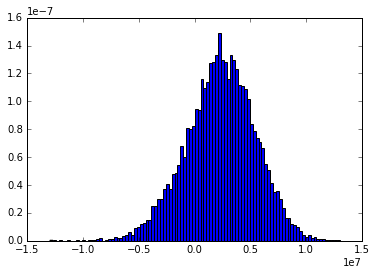

In [79]:
something = PayoffProfiles(1350,  25000, 2500,  1.22, 0.122, 1000, 1000000)
something._draw_volume_()
something.unhedged_profile(10000)

mean 2249235.21177
stDev: 443658.625648
min :-326471.97496163566
skew :0.36730899072911954


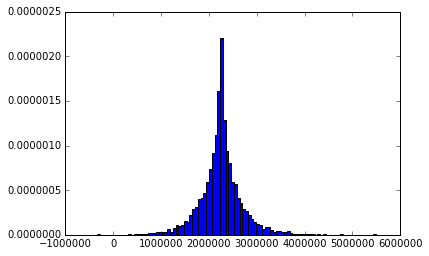

In [64]:
something.hedged_profit_forward(10000)

1702.09338101
mean 3466859.56967
stDev: 1736366.86931
min :-1423935.66031
skew :1.504096642700333


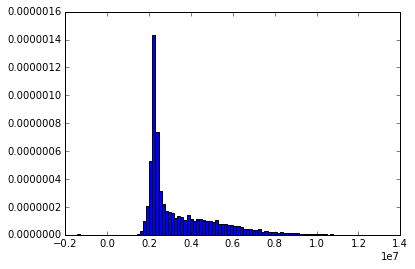

In [77]:
something.hedged_profit_vanilla(10000)

In [11]:
import sys

In [14]:
print(sys.path)

['', 'C:\\Users\\cp85vc\\AppData\\Local\\Continuum\\Anaconda3\\python35.zip', 'C:\\Users\\cp85vc\\AppData\\Local\\Continuum\\Anaconda3\\DLLs', 'C:\\Users\\cp85vc\\AppData\\Local\\Continuum\\Anaconda3\\lib', 'C:\\Users\\cp85vc\\AppData\\Local\\Continuum\\Anaconda3', 'c:\\users\\cp85vc\\appdata\\local\\continuum\\anaconda3\\lib\\site-packages\\setuptools-20.3-py3.5.egg', 'C:\\Users\\cp85vc\\AppData\\Local\\Continuum\\Anaconda3\\lib\\site-packages', 'C:\\Users\\cp85vc\\AppData\\Local\\Continuum\\Anaconda3\\lib\\site-packages\\Sphinx-1.3.5-py3.5.egg', 'C:\\Users\\cp85vc\\AppData\\Local\\Continuum\\Anaconda3\\lib\\site-packages\\win32', 'C:\\Users\\cp85vc\\AppData\\Local\\Continuum\\Anaconda3\\lib\\site-packages\\win32\\lib', 'C:\\Users\\cp85vc\\AppData\\Local\\Continuum\\Anaconda3\\lib\\site-packages\\Pythonwin', 'C:\\Users\\cp85vc\\AppData\\Local\\Continuum\\Anaconda3\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\cp85vc\\.ipython']


In [18]:
FXOption_class.printhello()

hello
